In [1]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/archive.zip

Mounted at /content/drive


In [3]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [4]:
train_path = "Train"
labels = []
data = []
CLASSES = 43

for i in range(CLASSES):
    img_path = os.path.join(train_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)


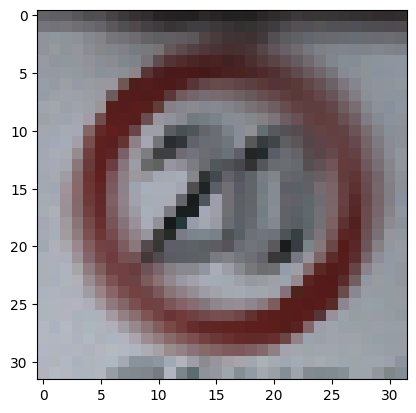

In [5]:
plt.imshow(data[0])

In [6]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

# Размер изображений
img_size = (224, 224)

# Создание модели
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(43, activation='softmax'))
model.layers[2].trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [7]:
# Компиляция модели
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 97s 119ms/step - accuracy: 0.4664 - loss: 2.2369 - val_accuracy: 0.1465 - val_loss: 3.5065
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9287 - loss: 0.2606 - val_accuracy: 0.8464 - val_loss: 0.5801
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9650 - loss: 0.1368 - val_accuracy: 0.9502 - val_loss: 0.1875
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9726 - loss: 0.1004 - val_accuracy: 0.9191 - val_loss: 0.3264
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9828 - loss: 0.0661 - val_accuracy: 0.9669 - val_loss: 0.1353


In [8]:
# Сохранение модели
model.save('ResNet50.h5')

# Сохранение истории обучения
with open('history_resnet.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Альтернативное сохранение
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5


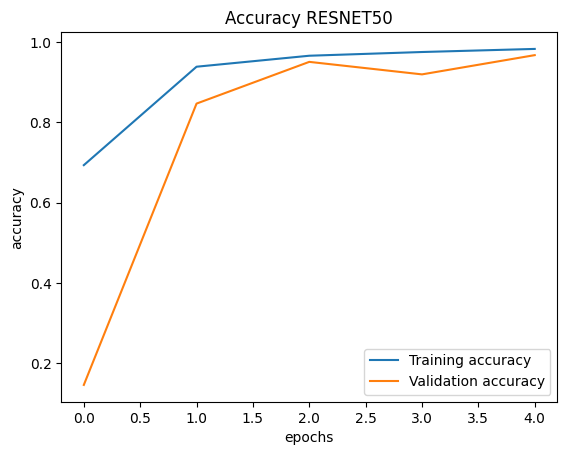

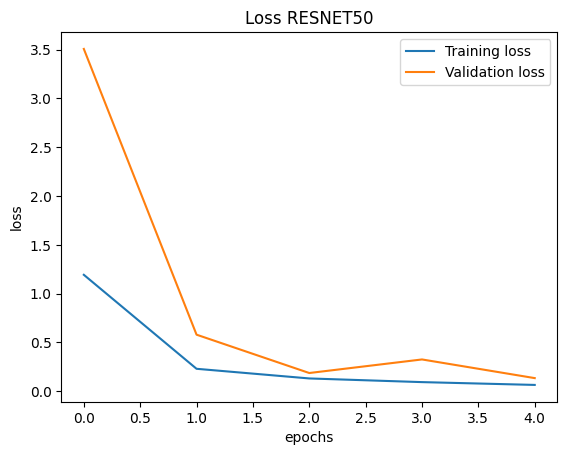

In [9]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Accuracy RESNET50")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss RESNET50")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.show()

In [10]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)


In [11]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9161 - loss: 0.4160
Test loss: 0.41843366622924805
Test accuracy: 0.9157561659812927


In [12]:
del model
del history

img_size = (224, 224)
model = Sequential()
model.add(VGG16(include_top=False, pooling='avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation="softmax"))
model.layers[2].trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
# Компиляция модели
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.0723 - loss: 8.7705 - val_accuracy: 0.3377 - val_loss: 1.9696
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 57s 42ms/step - accuracy: 0.4641 - loss: 1.6091 - val_accuracy: 0.7394 - val_loss: 0.7035
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8311 - loss: 0.5226 - val_accuracy: 0.8966 - val_loss: 0.4070
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9366 - loss: 0.2352 - val_accuracy: 0.9727 - val_loss: 0.0923
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9659 - loss: 0.1521 - val_accuracy: 0.9833 - val_loss: 0.0681


In [14]:
save_model(model, "VGG16.h5")
with open("history_VGG16.pkl", "wb") as file:
    pickle.dump(history.history, file)
!cp ResNet50.h5 drive/MyDrive/ResNet50.h5

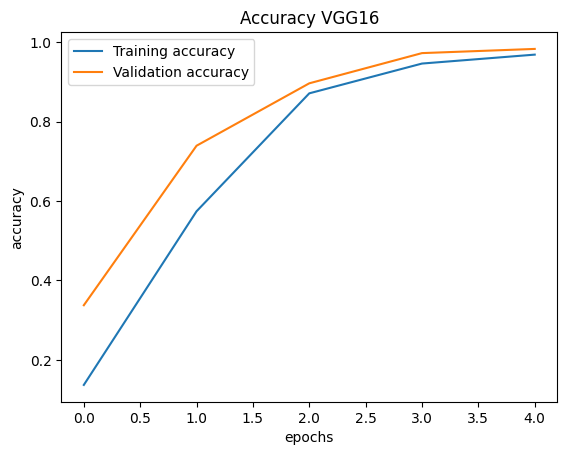

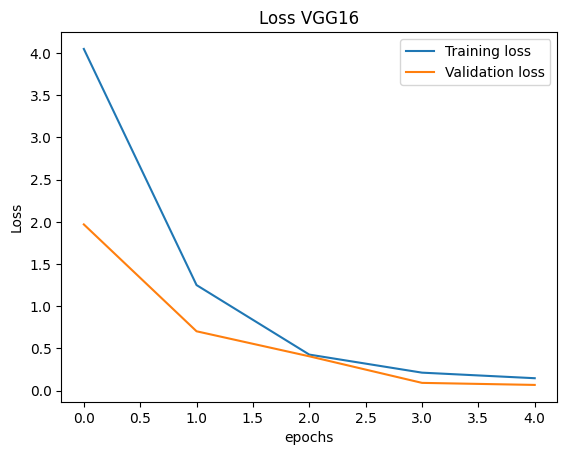

In [15]:
plt.figure(0)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title("Accuracy VGG16")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss VGG16")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [16]:
loss, accuracy = model.evaluate(data, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9501 - loss: 0.2537
Test loss: 0.25745609402656555
Test accuracy: 0.9492478370666504
